<a href="https://colab.research.google.com/github/divyam-prajapati/ML_Project/blob/main/ML_PROJECT_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy.random as npr
import math


class StockLSTM:
    def __init__(self, inputNodes=2, lstmCellWeigcurrentOutputs=2, outputNodes=1, learningRate=0.0002):
        self.inputNodes = inputNodes
        self.lstmCellWeigcurrentOutputs = lstmCellWeigcurrentOutputs
        self.outputNodes = outputNodes


        self.weigcurrentOutputsForgetGate = npr.randn(self.inputNodes, self.lstmCellWeigcurrentOutputs).T
        self.weigcurrentOutputsInputGate = npr.randn(self.inputNodes, self.lstmCellWeigcurrentOutputs).T
        self.weigcurrentOutputsOutputGate = npr.randn(self.inputNodes, self.lstmCellWeigcurrentOutputs).T
        self.weigcurrentOutputsCandidateGate = npr.randn(self.inputNodes, self.lstmCellWeigcurrentOutputs).T
        self.weigcurrentOutputsLstmToOutputGate = npr.randn(self.lstmCellWeigcurrentOutputs, self.outputNodes).T

        self.cs = [[1, 1]] * 100
        self.cs = np.array(self.cs, dtype=float)
        self.cs = np.array(self.cs, ndmin=2).T

        self.learningRate = learningRate

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def tanh(self, x):
        return 1 - np.square(np.tanh(x))

    def FG(self, gateInput, prevOutput=1):
        gateInput = np.dot(self.weigcurrentOutputsForgetGate, gateInput)
        gateInput = prevOutput * gateInput
        gateOutput = self.sigmoid(gateInput)
        self.cs = self.cs * gateOutput


    def IG(self, gateInput, prevOutput=1):
        gateInput1 = np.dot(self.weigcurrentOutputsInputGate, gateInput)
        gateInput1 = prevOutput * gateInput1
        gateInput2 = np.dot(self.weigcurrentOutputsCandidateGate, gateInput)
        gateInput2 = prevOutput * gateInput2
        gateOutput = self.sigmoid(gateInput1) * self.tanh(gateInput2)
        self.cs = self.cs + gateOutput


    def OG(self, gateInput, prevOutput=1):
        gateInput = np.dot(self.weigcurrentOutputsOutputGate, gateInput)
        gateInput = prevOutput * gateInput
        gateOutput = self.sigmoid(gateInput)
        prevOutput = self.tanh(self.cs) * gateOutput

        return prevOutput

    def feedForward(self, x1, x2, x3):
        self.cs = [[1, 1]] * len(x1[0])
        self.cs = np.array(self.cs, dtype=float)
        self.cs = np.array(self.cs, ndmin=2).T

        self.FG(x1)
        self.IG(x1)
        currentOutput = self.OG(x1)

        self.FG(x2, currentOutput)
        self.IG(x2, currentOutput)
        currentOutput = self.OG(x2, currentOutput)

        self.FG(x3, currentOutput)
        self.IG(x3, currentOutput)
        currentOutput = self.OG(x3, currentOutput)

        finalInput = np.dot(self.weigcurrentOutputsLstmToOutputGate, currentOutput)

        finalOutput = self.sigmoid(finalInput)

        return finalOutput, currentOutput

    def error(self, y, finalOutput):
        outputError = y - finalOutput
        hiddenError = np.dot(self.weigcurrentOutputsLstmToOutputGate.T, outputError)

        return outputError, hiddenError

    def backpropagation(self,x1, x2, x3, currentOutput, finalOutput, outputError, cellError):
        self.weigcurrentOutputsLstmToOutputGate += self.learningRate * np.dot((outputError * finalOutput * (1.0 - finalOutput)), currentOutput.T)

        self.weigcurrentOutputsForgetGate += self.learningRate * np.dot((cellError * currentOutput * (1.0 - currentOutput)), x1.T)
        self.weigcurrentOutputsInputGate += self.learningRate * np.dot((cellError * currentOutput * (1.0 - currentOutput)), x2.T)
        self.weigcurrentOutputsCandidateGate += self.learningRate * np.dot((cellError * currentOutput * (1.0 - currentOutput)), x2.T)
        self.weigcurrentOutputsOutputGate += self.learningRate * np.dot((cellError * currentOutput * (1.0 - currentOutput)), x3.T)


    def train(self, x1, x2, x3, y):
        x1 = np.atleast_2d(x1).T
        x2 = np.atleast_2d(x2).T
        x3 = np.atleast_2d(x3).T
        y = np.atleast_2d(y).T

        finalOutput, currentOutput = self.feedForward(x1, x2, x3)

        outputError, cellError = self.error(y, finalOutput)

        self.backpropagation(x1, x2, x3, currentOutput, finalOutput, outputError, cellError)

        return finalOutput

    def test(self, test1, test2, test3):
        test1 = test1.T
        test2 = test2.T
        test3 = test3.T
        finalOutput, currentOutput = self.feedForward(test1, test2, test3)
        return finalOutput

def main(data, trainRatio, lr, epochs, div):

    print("\n2] Scale Data")
    dataset = data.values
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    total_data_len = len(scaled_data)
    splitat = math.ceil(trainRatio*total_data_len)

    print("\n3] Preprocessing Training Data")
    train_data = scaled_data[0:splitat, :]
    xtrain1 = []
    xtrain2 = []
    xtrain3 = []
    ytrain = []

    for i in range(6, len(train_data)):
        xtrain1.append(train_data[i-6:i-4,0].tolist())
        xtrain2.append(train_data[i-4:i-2,0].tolist())
        xtrain3.append(train_data[i-2:i,0].tolist())
        ytrain.append([train_data[i,0]])

    xtrain1 = np.array(xtrain1, dtype=float)
    xtrain2 = np.array(xtrain2, dtype=float)
    xtrain3 = np.array(xtrain3, dtype=float)
    ytrain = np.array(ytrain, dtype=float)
    print(xtrain1.shape, xtrain2.shape, xtrain3.shape, ytrain.shape)

    print("\n4] Start Training")
    model = StockLSTM(learningRate = lr)
    rmse={}
    r2={}
    for cycle in range(epochs):
        for n in xtrain1:
            output = model.train(xtrain1, xtrain2, xtrain3, ytrain)
        if cycle%div == 0:
            actual = scaler.inverse_transform(ytrain)
            predicted = scaler.inverse_transform(output)
            predicted = predicted.T
            rmse[cycle] =  np.sqrt(np.mean(((predicted - actual) ** 2)))
            r2[cycle] = r2_score(actual, predicted)
            plt.plot(actual.flatten())
            plt.plot(predicted.flatten())
            plt.title('Model Results After ' + str(cycle) + ' Epochs')
            plt.legend(['Train Actual', 'Train Predicted'], loc='upper left')
            plt.show()
            print("--------------------------------------------------------------------------------------------------\n")

    predicted = scaler.inverse_transform(output)
    actual = scaler.inverse_transform(ytrain)
    predicted = predicted.T
    print("RMSE: ", np.sqrt(np.mean(((predicted - actual) ** 2))))
    print("R2: ", r2_score(actual,predicted))
    print("--------------------------------------------------------------------------------------------------\n")

    # print(history)

    print("\n5] Preprocess Test Data")
    # Test
    test_data = scaled_data[splitat:, :]
    test1 = []
    test2 = []
    test3 = []
    testOuput = []

    for i in range(6, len(test_data)):
        test1.append(test_data[i-6:i-4,0].tolist())
        test2.append(test_data[i-4:i-2,0].tolist())
        test3.append(test_data[i-2:i,0].tolist())
        testOuput.append([test_data[i,0]])

    test1 = np.array(test1, dtype=float)
    test2 = np.array(test3, dtype=float)
    test3 = np.array(test3, dtype=float)
    testOuput = np.array(testOuput, dtype=float)

    print(test1.shape, test2.shape, test3.shape, testOuput.shape)

    print("\n6] Model on Test Data")
    test = model.test(test1, test2, test3)

    test_predicted = scaler.inverse_transform(test)
    test_actual = scaler.inverse_transform(testOuput)
    test_predicted = test_predicted.T
    print("RMSE: ", np.sqrt(np.mean(((test_predicted - test_actual) ** 2))))
    print("R2: ", r2_score(test_actual,test_predicted))
    print("--------------------------------------------------------------------------------------------------\n")

    print("\n7] Visualizations")

    traindf = pd.DataFrame({'Actual': actual.flatten(), 'Predicted': predicted.flatten()})
    print("Train")
    print(traindf)
    plt.plot(traindf['Actual'])
    plt.plot(traindf['Predicted'])
    plt.legend(['Train Actual', 'Train Predicted'], loc='upper left')
    plt.show()
    print("--------------------------------------------------------------------------------------------------\n")

    testdf = pd.DataFrame({'Actual': test_actual.flatten(), 'Predicted': test_predicted.flatten()})
    print("Test")
    print(testdf)

    plt.plot(testdf['Actual'])
    plt.plot(testdf['Predicted'])
    plt.legend(['Test Actual', 'Test Predicted'], loc='upper left')
    plt.show()
    print("--------------------------------------------------------------------------------------------------\n")

    testdf['Predicted'].index = [splitat + i for i in range(len(testdf['Predicted']))]
    plt.plot(traindf['Actual'].append(testdf['Actual'], ignore_index=True))
    plt.plot(testdf['Predicted'])
    plt.legend(['Test Actual', 'Test Predicted'], loc='upper left')
    plt.show()

    lists = sorted(rmse.items())
    lists1 = sorted(r2.items())
    x, y = zip(*lists)
    x1, y1 = zip(*lists1)
    plt.plot(x, y)
    plt.plot(x1, y1)
    plt.legend(['RMSE', 'R^2'], loc='upper left')
    plt.show()



########################################################################  AAL  ########################################################################



1] Fetching Data

2] Scale Data

3] Preprocessing Training Data
(3431, 2) (3431, 2) (3431, 2) (3431, 1)

4] Start Training


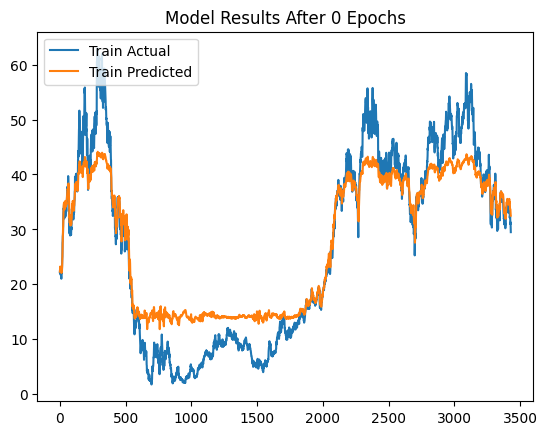

--------------------------------------------------------------------------------------------------



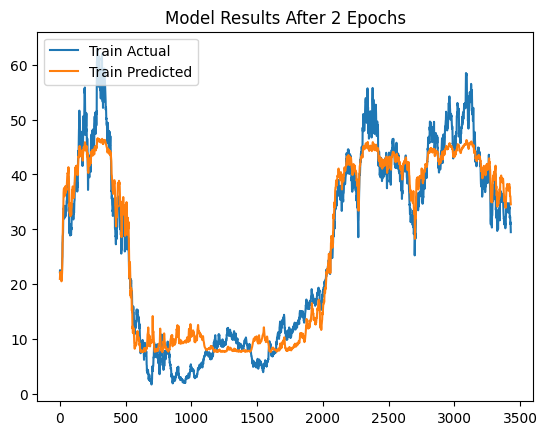

--------------------------------------------------------------------------------------------------

RMSE:  4.192441286615152
R2:  0.940662361750468
--------------------------------------------------------------------------------------------------


5] Preprocess Test Data
(1139, 2) (1139, 2) (1139, 2) (1139, 1)

6] Model on Test Data
RMSE:  3.5894013134712384
R2:  0.6213746130985449
--------------------------------------------------------------------------------------------------


7] Visualizations
Train
         Actual  Predicted
0     22.200001  22.209467
1     22.580000  22.998430
2     22.150000  23.306909
3     22.209999  23.519184
4     21.980000  23.209446
...         ...        ...
3426  31.740000  37.022935
3427  30.959999  36.896043
3428  31.299999  36.276983
3429  29.920000  35.955098
3430  29.500000  35.621321

[3431 rows x 2 columns]


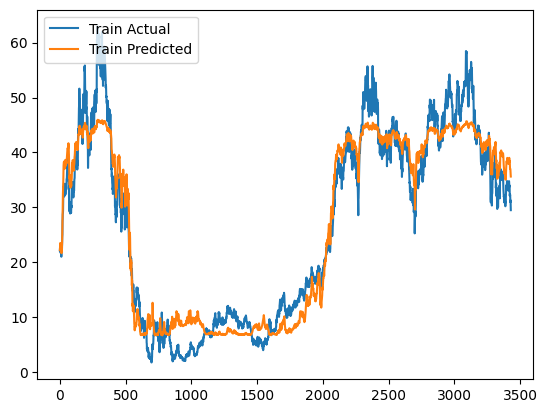

--------------------------------------------------------------------------------------------------

Test
         Actual  Predicted
0     29.120001  31.459598
1     30.360001  32.390253
2     30.379999  34.312349
3     30.920000  35.095410
4     30.760000  35.298222
...         ...        ...
1134  13.350000   8.538528
1135  13.130000   8.876736
1136  13.480000   8.977645
1137  13.910000   8.989300
1138  13.760000   9.357640

[1139 rows x 2 columns]


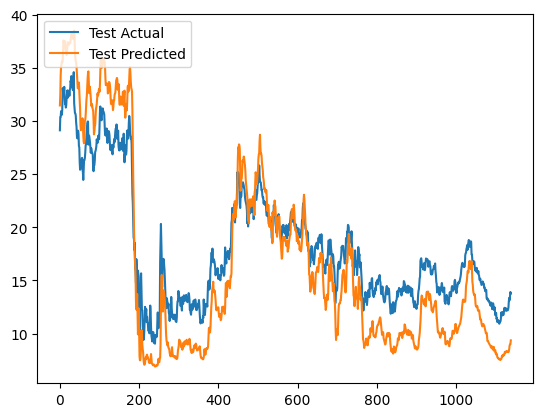

--------------------------------------------------------------------------------------------------



<ipython-input-17-a794166b5803>:228: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plt.plot(traindf['Actual'].append(testdf['Actual'], ignore_index=True))


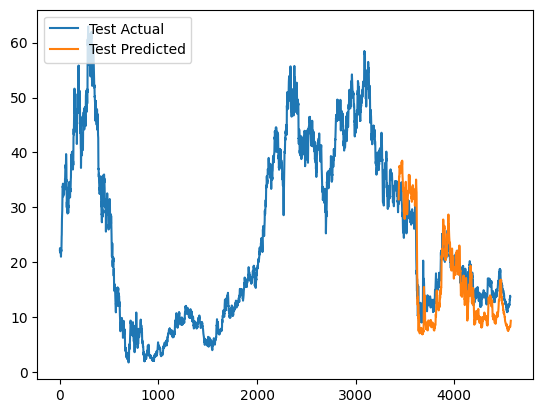

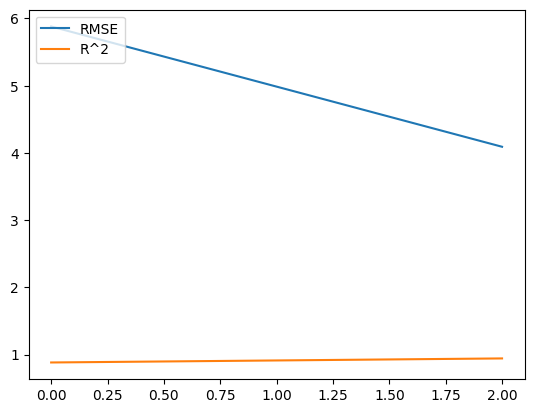



####################################################################################################################################################




In [ ]:
stock = "AAL"
len_training_data = 0.75
lr = 0.0002
training_cycles = 4
div = 2

print("\n\n########################################################################  " + stock + "  ########################################################################\n\n")
print("\n1] Fetching Data")
df = pd.read_csv("https://raw.githubusercontent.com/divyam-prajapati/ML_Project/main/datasets/"+stock+"_data.csv")
df.index = df['Date'].astype('datetime64')
df.drop(columns=['Date'],inplace=True)
data = df.filter(['Close'])
main(data, len_training_data, lr, training_cycles, div)
print("\n\n####################################################################################################################################################\n\n")



########################################################################  NVDA  ########################################################################



1] Fetching Data

2] Scale Data

3] Preprocessing Training Data
(3771, 2) (3771, 2) (3771, 2) (3771, 1)

4] Start Training


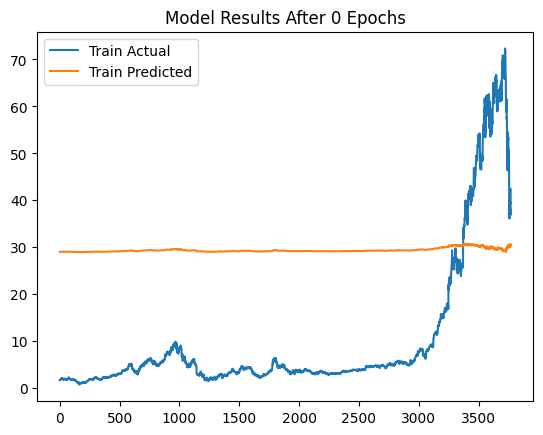

--------------------------------------------------------------------------------------------------



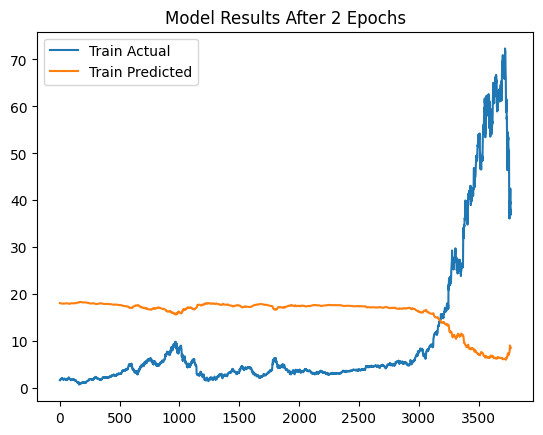

--------------------------------------------------------------------------------------------------



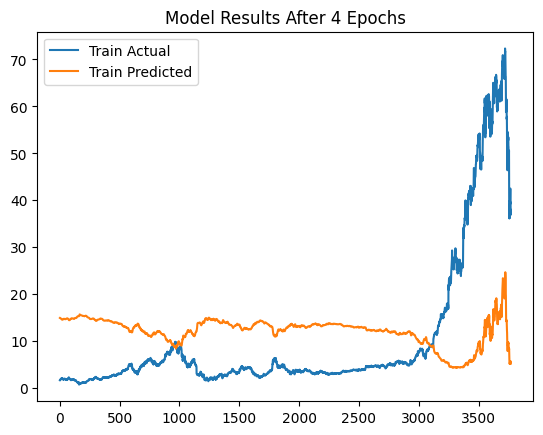

--------------------------------------------------------------------------------------------------



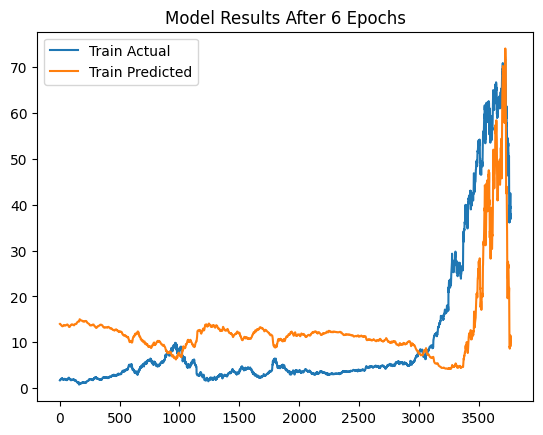

--------------------------------------------------------------------------------------------------

RMSE:  10.189670178253937
R2:  0.5807085267836629
--------------------------------------------------------------------------------------------------


5] Preprocess Test Data
(1252, 2) (1252, 2) (1252, 2) (1252, 1)

6] Model on Test Data
RMSE:  84.05392654707987
R2:  0.5174735770328163
--------------------------------------------------------------------------------------------------


7] Visualizations
Train
         Actual  Predicted
0      1.691667  13.541435
1      1.730000  13.501253
2      1.755833  13.473343
3      1.758333  13.485048
4      1.830000  13.486538
...         ...        ...
3766  42.509998  12.354780
3767  39.277500  14.011354
3768  39.572498  13.250839
3769  36.902500  11.998927
3770  37.965000  11.035993

[3771 rows x 2 columns]


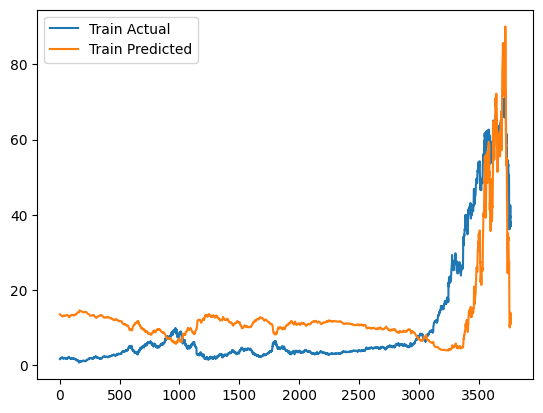

--------------------------------------------------------------------------------------------------

Test
          Actual   Predicted
0      34.627499    9.500705
1      33.775002    9.074833
2      32.392502    8.227591
3      31.770000    7.611079
4      33.275002    7.168120
...          ...         ...
1247  455.100006  252.437390
1248  465.660004  252.437266
1249  455.029999  252.437255
1250  465.959991  252.437245
1251  475.059998  252.437257

[1252 rows x 2 columns]


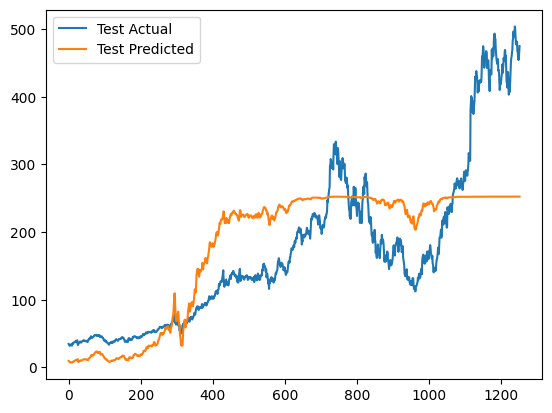

--------------------------------------------------------------------------------------------------



<ipython-input-17-a794166b5803>:228: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plt.plot(traindf['Actual'].append(testdf['Actual'], ignore_index=True))


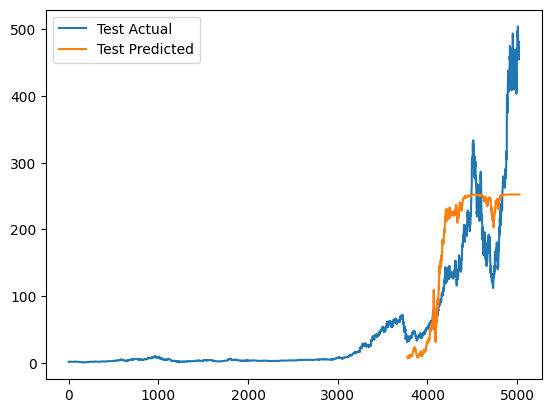

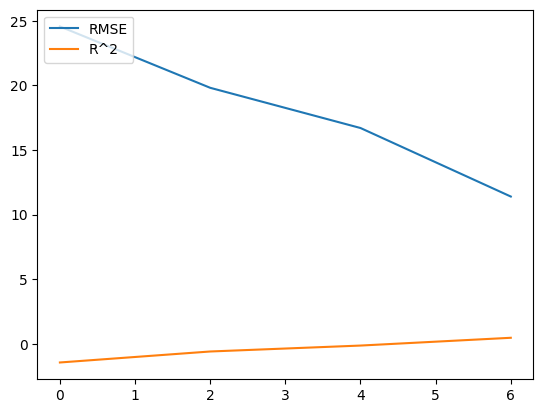



####################################################################################################################################################




In [ ]:
stock = "NVDA"

len_training_data = 0.75
lr = 0.0002
training_cycles = 8
div = 2

print("\n\n########################################################################  " + stock + "  ########################################################################\n\n")
print("\n1] Fetching Data")
df = pd.read_csv("https://raw.githubusercontent.com/divyam-prajapati/ML_Project/main/datasets/"+stock+"_data.csv")
df.index = df['Date'].astype('datetime64')
df.drop(columns=['Date'],inplace=True)
data = df.filter(['Close'])
main(data, len_training_data, lr, training_cycles, div)
print("\n\n####################################################################################################################################################\n\n")